In [15]:
import numpy as np
import cv2 as cv
from skimage.morphology import skeletonize
import glob
import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from PIL import Image
import sknw
import networkx as nx
import random
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import linregress
import pymannkendall as mk

In [2]:
data = pd.read_excel("data.xlsx")

In [3]:
df = pd.DataFrame(columns=["year", "length"])
for a in tqdm.tqdm(glob.glob("skeletons/*.png")):
    
    #Read skeleton and transform it into a graph
    ark = a[10:-7]
    im = cv.imread(a, cv.IMREAD_GRAYSCALE).astype(np.uint16)
    year = data[data.ark == "12148_"+ark].date.values[0]
    if year != year:
        continue

    G = sknw.build_sknw(im)
    
    #Remove small segments
    deg = G.degree
    to_delete = []
    for node in G.nodes(data=True):
        if deg[node[0]] == 1:
            for neighbor in G.neighbors(node[0]):
                if np.linalg.norm(node[1]['o']-G.nodes[neighbor]['o']) < 30:
                    to_delete.append(node[0])
                    
    for node in to_delete:
        G.remove_node(node)
        
    #Add weights to the edges corresponding to the euclidean distance between the nodes                
    for (s,e) in G.edges():
        G[s][e]['weight'] = np.linalg.norm(G.nodes[e]['o']-G.nodes[s]['o'])

    number_of_paths = 0

    #Pick the 5 test points
    coords = ([4500,3500], [5500,4500], [5500,3500], [4500,4500], [5078,4248])
    target_nodes = []
    dist = 30
    for coord in coords:
        found = False
        while not found and dist < 100:
            for node in G.nodes(data=True):
                if np.linalg.norm(node[1]['o']-np.array(coord)) < dist:
                    target_nodes.append(node[0])
                    found = True
                    break
            if found:
                break
            dist += 20
    if not found:
        continue
    #Compute the shortest path between the 5 pairs of test points
    path_length = 0
    for src_node in target_nodes:
        for trgt_node in target_nodes:
            if src_node == trgt_node:
                continue
            try:
                path_length += nx.shortest_path_length(G, src_node, trgt_node, weight='weight')
                number_of_paths+=1
            except:
                pass
    
    if number_of_paths == 20:
        df = df.append({"length":(path_length/2)*1.19, "year":year}, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████| 346/346 [09:45<00:00,  1.69s/it]


In [4]:
q=10
groups = np.percentile(df.year, range(q,101,q))

In [5]:
groups

array([1840., 1844., 1848., 1855., 1865., 1876., 1882., 1889., 1907.,
       1948.])

In [6]:
df.year.min()

1785.0

In [7]:
def divide_in_groups(year):
    i = 0
    while year > groups[i]:
        i+=1
    return i

In [8]:
df["group"] = df.year.apply(divide_in_groups)

In [9]:
median_per_group = {}
for i in range(len(groups)):
    median_per_group[i] = np.percentile(df[df["group"]== i].length, 50)

In [10]:
def is_below_median(row):
    return row["length"] < median_per_group[row["group"]]

In [11]:
df["below_median"] = df.apply(is_below_median, axis=1)
only_take = df[df.below_median == True]
only_take = only_take[(only_take.group != 0)&(only_take.group!=9)]

In [12]:
only_take["km"] = df.length.apply(lambda m : m/1000)

In [13]:
ticks = []
for i in range(1,len(groups)-1):
    ticks.append(f"{int(groups[i-1])} - {int(groups[i])}")
    

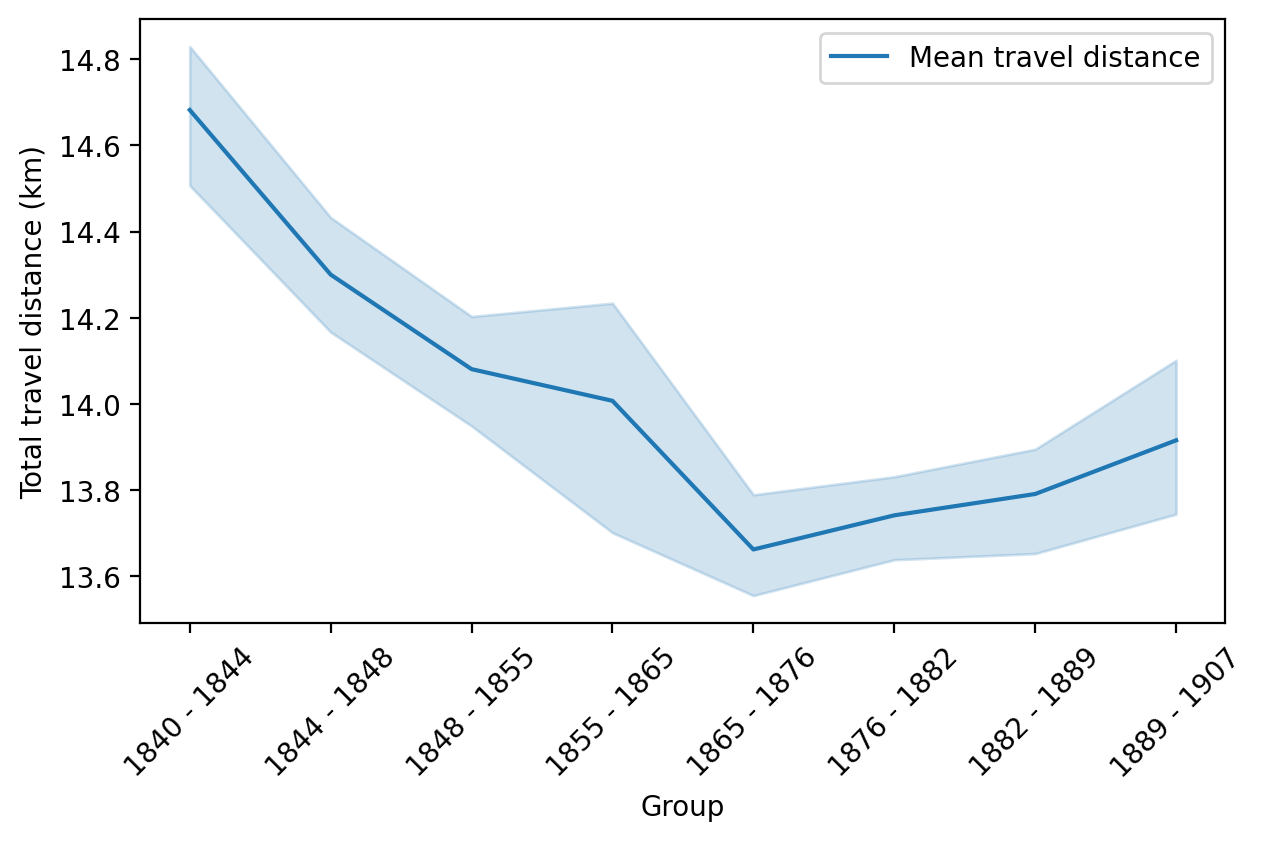

In [14]:
sns.reset_orig()
f, ax = plt.subplots(figsize=(7, 4), dpi=200)
ax = sns.lineplot(data=only_take, x="group", y = "km", label="Mean travel distance", markers=True)

ax.set_xlabel("Group")
ax.set_ylabel("Total travel distance (km)")
ax.set_xticks(range(1,9))
ax.set_xticklabels(ticks)
plt.xticks(rotation=45)
plt.show()

array([14.68209777, 14.30010785, 14.080717  , 14.00723   , 13.66228643,
       13.74150162, 13.79101548, 13.91554853])

In [22]:
mk.original_test(only_take.groupby(by="group").mean().km.values, alpha=0.10)

Mann_Kendall_Test(trend='decreasing', h=True, p=0.06348653056076747, z=-1.8557687223952255, Tau=-0.5714285714285714, s=-16.0, var_s=65.33333333333333, slope=-0.11128941205963211, intercept=14.350902211782318)